# Amplitude Matching for Multizone Sound Field Control

A multizone sound field control method to synthesize a desired amplitude (or magnitude) distributions over a target region with multiple loudspeakers
- Paper: https://doi.org/10.1109/TASLP.2022.3231715
- Codes: https://github.com/sh01k/AmplitudeMatching

by Takumi Abe, [Shoichi Koyama](https://www.sh01.org/), [Natsuki Ueno](https://natsuenono.github.io/), and [Hiroshi Saruwatari](https://researchmap.jp/read0102891/)

## Codes for reproducing results in Sect. IV-A (1)
### General settings

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as distfuncs
from scipy import optimize
from scipy import stats

import sf_func as sf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
plt.rcParams["font.size"] = 18 # Font size for plots

c = 340 # Sound speed (m/s)

# Simulated rectangular region 
lenX = 4.0 # Length in y
lenY = 4.0 # Length in y

dx, dy = 0.05, 0.05 # Intervals

# Simulated positions
xvecSim = np.arange(-lenX/2.0, lenX/2.0 + dx, dx)
yvecSim = np.arange(-lenY/2.0, lenY/2.0 + dy, dy)
ySim, xSim = np.meshgrid(yvecSim, xvecSim)
posSim = np.concatenate([xSim.reshape([-1,1]), ySim.reshape([-1,1])], 1)

# Number of simulated positions
numSimX = xSim.shape[0]
numSimY = xSim.shape[1]
numSim = (numSimX, numSimY)

### Table I and Figure 4: Evaluation at single frequency

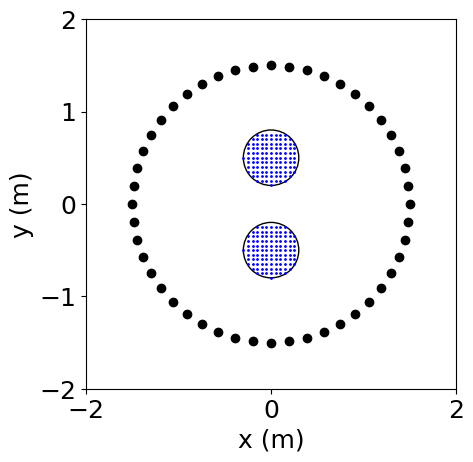

In [12]:
"""Parameters"""

freq = 1400 # Frequency
k = 2.0 * np.pi *freq / c # Wave number

radSPK = 1.5 # Radius of circlular loudspeaker array
numSPK = 48 # Number of loudspeakers
posSPK = sf.CircularGrid(radSPK, numSPK) # Loudspeaker positions

radCP = 0.3 # Radius of circular target regions
centCP_U = np.array([0.0, 0.5])[None,:] # Center position of upper target region
centCP_L = np.array([0.0, -0.5])[None,:] # Center position of lower target region
centCP = np.concatenate([centCP_U, centCP_L], 0)

# Control points in upper target region
distCP_U = distfuncs.cdist(posSim, centCP_U)
idxCP_U = np.where(distCP_U <= radCP)[0]
posCP_U = posSim[idxCP_U, :] 
numCP_U = posCP_U.shape[0]

# Control points in lower target region
distCP_L = distfuncs.cdist(posSim, centCP_L)
idxCP_L = np.where(distCP_L <= radCP)[0]
posCP_L = posSim[idxCP_L, :] 
numCP_L = posCP_L.shape[0]

idxCP = np.concatenate([idxCP_U, idxCP_L]) # Indexes of total control points
posCP = posSim[idxCP, :] # Position of total control points
numCP = posCP.shape[0] # Number of control points

# Transfer Function Matrices
G = sf.TransFuncMat(posSPK, posCP, k)
GU = sf.TransFuncMat(posSPK, posCP_U, k) # For upper target region
GL = sf.TransFuncMat(posSPK, posCP_L, k) # For lower target region

# Regularization parameter
U, s, V = np.linalg.svd(G.conj().T @ G)
reg = np.max(s) * 1e-3

# Desired amplitude distribution
des_U = np.ones(numCP_U)
des_L = np.zeros(numCP_L)
des = np.concatenate([des_U, des_L])

# Draw points
fig, ax = plt.subplots()
ax.scatter(posSPK[:,0], posSPK[:,1], c='k')
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posCP[:,0], posCP[:,1], s=1, c='b')
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

MSE: -4.2, MSE_U: -1.2, MSE_L: -30.6, AC: 14.5


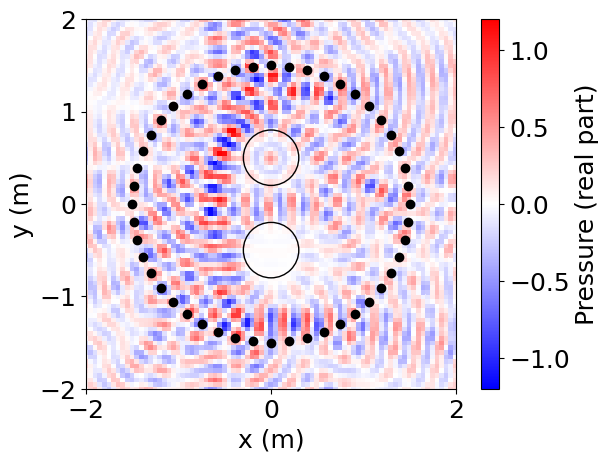

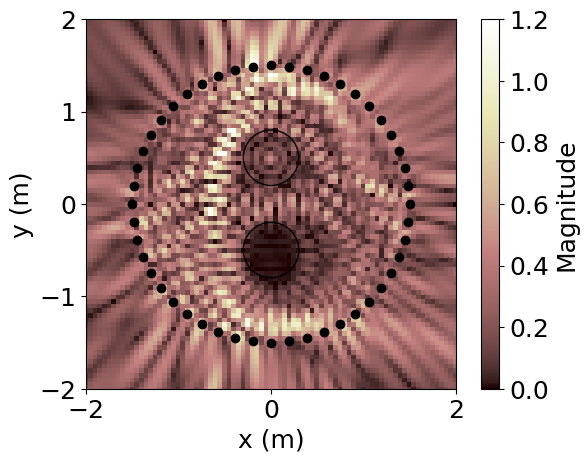

In [13]:
"""Pressure matching (PM) with zero phase"""

drvPM0 = sf.PressureMatching(G, reg, posSPK, des)
synPM0, synPM0_XY = sf.SynthSoundField(posSim, posSPK, drvPM0, numSim, k)

# Evaluation
MSE_PM0 = sf.MSE(synPM0[idxCP], des)
MSE_U_PM0 = sf.MSE(synPM0[idxCP_U], des_U)
MSE_L_PM0 = sf.MSE(synPM0[idxCP_L], des_L)
AC_PM0 = sf.AC(synPM0[idxCP_U], synPM0[idxCP_L])

print("MSE: %.1f, MSE_U: %.1f, MSE_L: %.1f, AC: %.1f" % (MSE_PM0, MSE_U_PM0, MSE_L_PM0, AC_PM0) )

# Plot
fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, synPM0_XY.real, cmap='bwr', vmin=-1.2, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Pressure (real part)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, np.abs(synPM0_XY), cmap='pink', vmin=0.0, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Magnitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.show()

MSE: -43.3, MSE_U: -41.0, MSE_L: -48.8, AC: 48.8


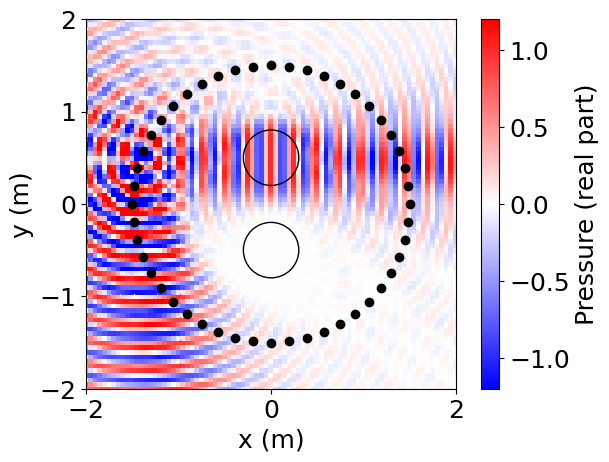

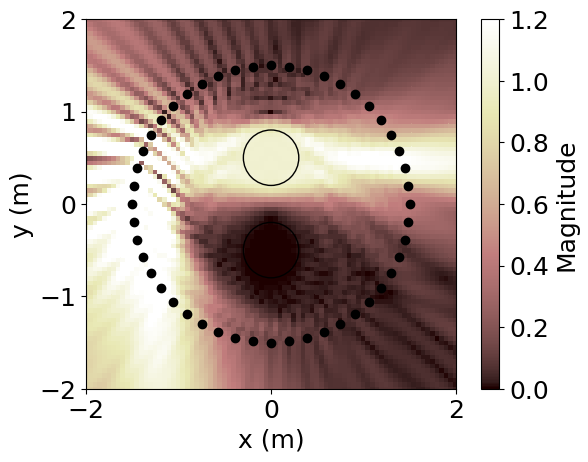

In [14]:
"""Pressure matching (PM) for synthesizing plane wave"""

pwAng = 0 # Plane wave propagation angle

des_U_pw = sf.PlaneWave(1.0, pwAng, posCP_U, k)
des_pw = np.concatenate([des_U_pw, des_L])

drvPM = sf.PressureMatching(G, reg, posSPK, des_pw)
synPM, synPM_XY = sf.SynthSoundField(posSim, posSPK, drvPM, numSim, k)

# Evaluation
MSE_PM = sf.MSE(synPM[idxCP], des)
MSE_U_PM = sf.MSE(synPM[idxCP_U], des_U)
MSE_L_PM = sf.MSE(synPM[idxCP_L], des_L)
AC_PM = sf.AC(synPM[idxCP_U], synPM[idxCP_L])

print("MSE: %.1f, MSE_U: %.1f, MSE_L: %.1f, AC: %.1f" % (MSE_PM, MSE_U_PM, MSE_L_PM, AC_PM) )

# Plot
fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, synPM_XY.real, cmap='bwr', vmin=-1.2, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Pressure (real part)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, np.abs(synPM_XY), cmap='pink', vmin=0.0, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Magnitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.show()

MSE: -6.4, MSE_U: -3.4, MSE_L: -67.9, AC: 67.9


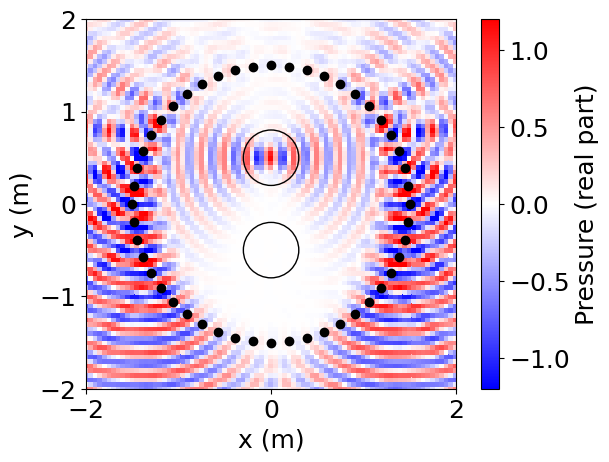

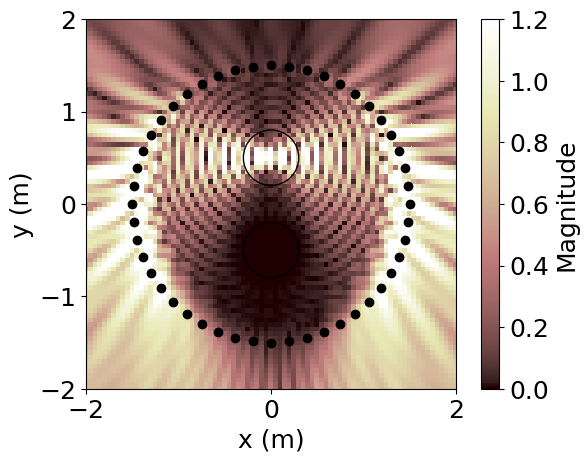

In [15]:
"""Acoustic contrast control (ACC)"""

drvACC = sf.AcoustContrastControl(GU, GL)

# Normalize amplitude 
synACCtmp, _ = sf.SynthSoundField(posSim, posSPK, drvACC, numSim, k)
ampACC = np.sqrt(synACCtmp[idxCP_U].shape[0]) / np.linalg.norm(synACCtmp[idxCP_U]) 
drvACC = ampACC * drvACC
synACC, synACC_XY = sf.SynthSoundField(posSim, posSPK, drvACC, numSim, k)

# Evaluation
MSE_ACC = sf.MSE(synACC[idxCP], des)
MSE_U_ACC = sf.MSE(synACC[idxCP_U], des_U)
MSE_L_ACC = sf.MSE(synACC[idxCP_L], des_L)
AC_ACC = sf.AC(synACC[idxCP_U], synACC[idxCP_L])

print("MSE: %.1f, MSE_U: %.1f, MSE_L: %.1f, AC: %.1f" % (MSE_ACC, MSE_U_ACC, MSE_L_ACC, AC_ACC) )

# Plot
fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, synACC_XY.real, cmap='bwr', vmin=-1.2, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Pressure (real part)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, np.abs(synACC_XY), cmap='pink', vmin=0.0, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Magnitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.show()


MSE: -16.0, MSE_U: -13.1, MSE_L: -35.3, AC: 35.1


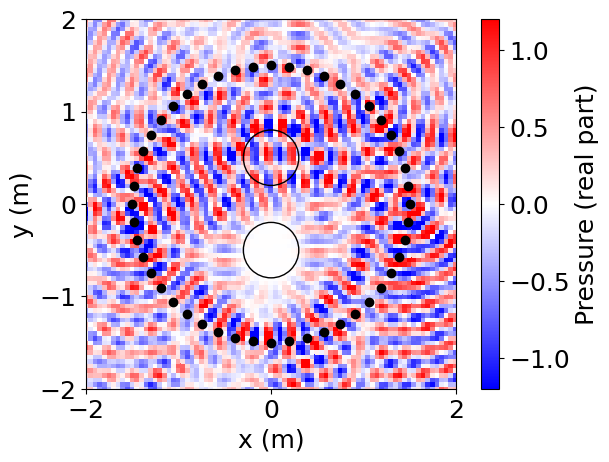

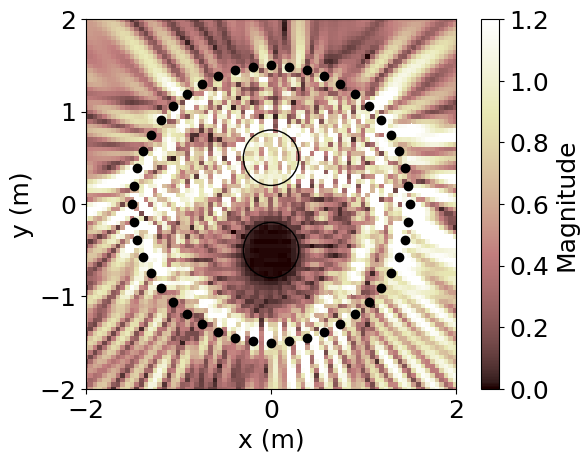

In [16]:
"""Amplitude matching by BFGS (AM-BFGS)"""

# Parameters
gtol = 1e-3
max_iter = 1000

# Initial value
drv0 = drvPM0
drv0Cmplx = np.concatenate([drv0.real, drv0.imag])

resBFGS = optimize.minimize(sf.CostFuncCmplxAM, drv0Cmplx, method='BFGS', args=(G, des, reg, numSPK), jac=sf.GradCostFuncCmplxAM, options={'gtol': gtol, 'maxiter' : max_iter})

drvAM_BFGS = resBFGS.x[:numSPK] + 1j * resBFGS.x[numSPK:]
synAM_BFGS, synAM_BFGS_XY = sf.SynthSoundField(posSim, posSPK, drvAM_BFGS, numSim, k)

# Evaluation
MSE_AM_BFGS = sf.MSE(synAM_BFGS[idxCP], des)
MSE_U_AM_BFGS = sf.MSE(synAM_BFGS[idxCP_U], des_U)
MSE_L_AM_BFGS = sf.MSE(synAM_BFGS[idxCP_L], des_L)
AC_AM_BFGS = sf.AC(synAM_BFGS[idxCP_U], synAM_BFGS[idxCP_L])

print("MSE: %.1f, MSE_U: %.1f, MSE_L: %.1f, AC: %.1f" % (MSE_AM_BFGS, MSE_U_AM_BFGS, MSE_L_AM_BFGS, AC_AM_BFGS) )

# Plot
fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, synAM_BFGS_XY.real, cmap='bwr', vmin=-1.2, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Pressure (real part)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, np.abs(synAM_BFGS_XY), cmap='pink', vmin=0.0, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Magnitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.show()

MSE: -15.3, MSE_U: -12.3, MSE_L: -35.5, AC: 35.2


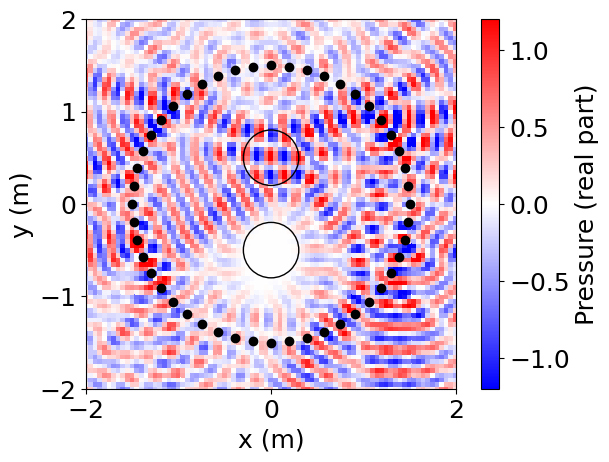

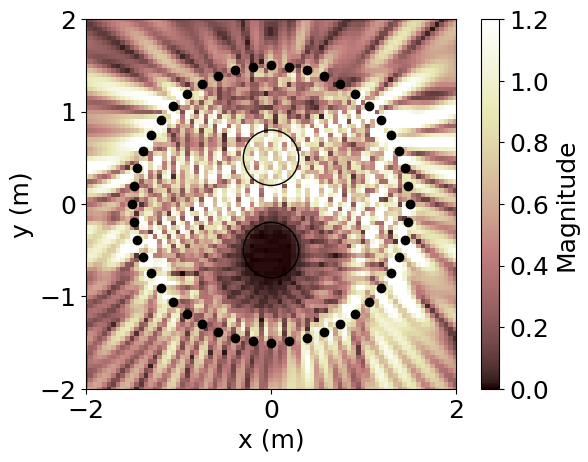

In [17]:
"""Amplitude matching by majorization minimization algorithm (AM-MM)"""

# Parameters
dtol = 1e-3
max_iter = 1000

# Initial value
drv0 = drvPM0

drvAM_MM, _ = sf.MM(numSPK, des, G, reg, drv0, dtol=dtol,  max_iter=max_iter)
synAM_MM, synAM_MM_XY = sf.SynthSoundField(posSim, posSPK, drvAM_MM, numSim, k)

# Evaluation
MSE_AM_MM = sf.MSE(synAM_MM[idxCP], des)
MSE_U_AM_MM = sf.MSE(synAM_MM[idxCP_U], des_U)
MSE_L_AM_MM = sf.MSE(synAM_MM[idxCP_L], des_L)
AC_AM_MM = sf.AC(synAM_MM[idxCP_U], synAM_MM[idxCP_L])

print("MSE: %.1f, MSE_U: %.1f, MSE_L: %.1f, AC: %.1f" % (MSE_AM_MM, MSE_U_AM_MM, MSE_L_AM_MM, AC_AM_MM) )

# Plot
fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, synAM_MM_XY.real, cmap='bwr', vmin=-1.2, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Pressure (real part)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, np.abs(synAM_MM_XY), cmap='pink', vmin=0.0, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Magnitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.show()

MSE: -36.4, MSE_U: -34.6, MSE_L: -39.4, AC: 39.3


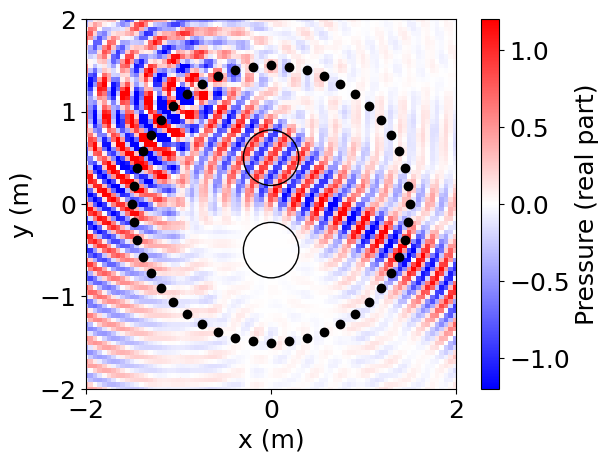

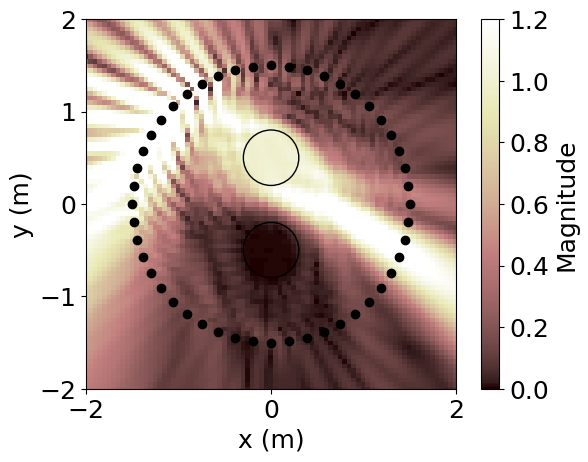

In [18]:
"""Amplitude matching by alternating direction method of multipliers (AM-ADMM)"""

# Parameters
dtol = 1e-3
max_iter = 1000

# Initial value
drv0 = drvPM0

# ADMM
drvAM_ADMM, _ = sf.ADMM(numSPK, des, G, reg, drv0, max_iter=max_iter, dtol=dtol)
synAM_ADMM, synAM_ADMM_XY = sf.SynthSoundField(posSim, posSPK, drvAM_ADMM, numSim, k)

# Evaluation
MSE_AM_ADMM = sf.MSE(synAM_ADMM[idxCP], des)
MSE_U_AM_ADMM = sf.MSE(synAM_ADMM[idxCP_U], des_U)
MSE_L_AM_ADMM = sf.MSE(synAM_ADMM[idxCP_L], des_L)
AC_AM_ADMM = sf.AC(synAM_ADMM[idxCP_U], synAM_ADMM[idxCP_L])

print("MSE: %.1f, MSE_U: %.1f, MSE_L: %.1f, AC: %.1f" % (MSE_AM_ADMM, MSE_U_AM_ADMM, MSE_L_AM_ADMM, AC_AM_ADMM) )

# Plot
fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, synAM_ADMM_XY.real, cmap='bwr', vmin=-1.2, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Pressure (real part)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, np.abs(synAM_ADMM_XY), cmap='pink', vmin=0.0, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Magnitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.show()

### Figure 3: Performance w.r.t. plane wave angles of desired sound field

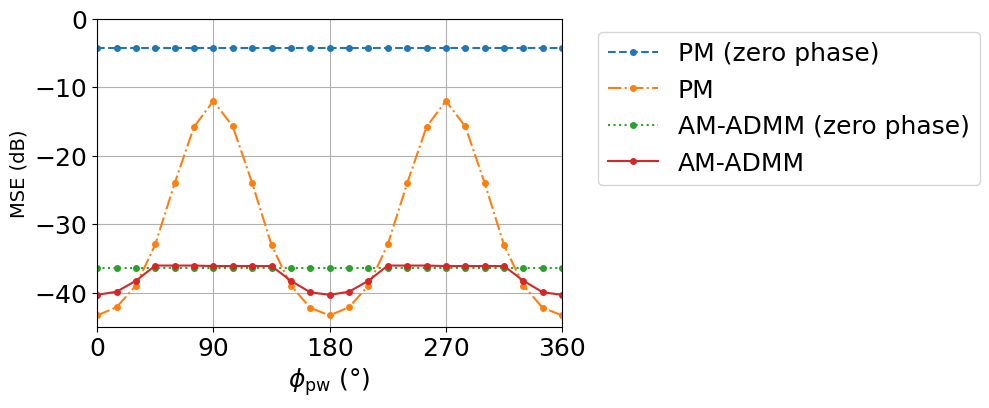

In [19]:
numAng = 25
pwAngVec = np.arange(numAng)*360/(numAng-1)

MSEvec_PM = []
MSEvec_PM0 = []
MSEvec_AM_ADMM = []
MSEvec_AM_ADMM0 = []

for i in range(numAng):
    pwAng = pwAngVec[i]*np.pi/180
    des_U_pw = sf.PlaneWave(1.0, pwAng, posCP_U, k)
    des_pw = np.concatenate([des_U_pw, des_L])

    # Pressure matching
    drvPM = sf.PressureMatching(G, reg, posSPK, des_pw)
    synPM, _ = sf.SynthSoundField(posSim, posSPK, drvPM, numSim, k)
    MSEvec_PM.append(sf.MSE(synPM[idxCP], des))

    # Amplitude matching
    drvAM_ADMM, _ = sf.ADMM(numSPK, des, G, reg, drvPM, max_iter=max_iter, dtol=dtol)
    synAM_ADMM, _ = sf.SynthSoundField(posSim, posSPK, drvAM_ADMM, numSim, k)
    MSEvec_AM_ADMM.append(sf.MSE(synAM_ADMM[idxCP], des))

    MSEvec_PM0.append(MSE_PM0)
    MSEvec_AM_ADMM0.append(MSE_AM_ADMM)

# Plot
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(pwAngVec, MSEvec_PM0, linestyle="--",marker="o",markersize=4, label="PM (zero phase)")
ax.plot(pwAngVec, MSEvec_PM, linestyle="-.",marker="o",markersize=4, label="PM")
ax.plot(pwAngVec, MSEvec_AM_ADMM0, linestyle=":",marker="o",markersize=4, label="AM-ADMM (zero phase)")
ax.plot(pwAngVec, MSEvec_AM_ADMM, linestyle="-",marker="o",markersize=4, label="AM-ADMM")
ax.set_xlim(0,360)
ax.set_ylim(-45, 0)
ax.set_xticks(np.linspace(0,360,5))
plt.xlabel(r'$\phi_{\rm{pw}}$ (°)')
plt.ylabel('MSE (dB)', fontsize = 14)
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.grid()

plt.show()


### Figures 5 and 6: Performance w.r.t. frequency

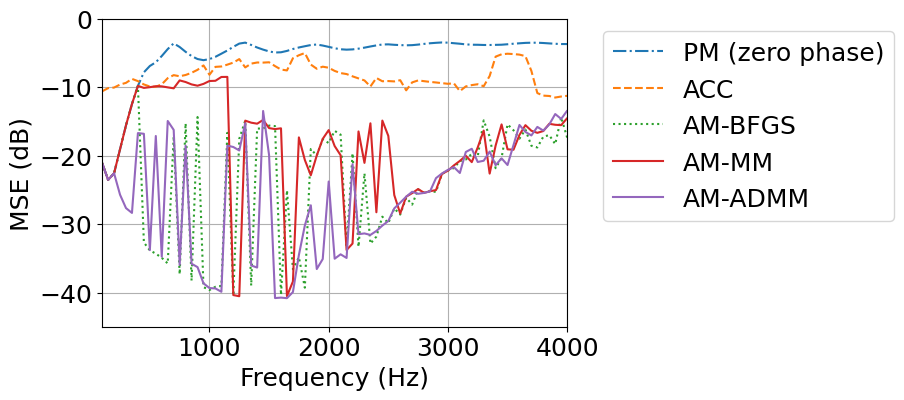

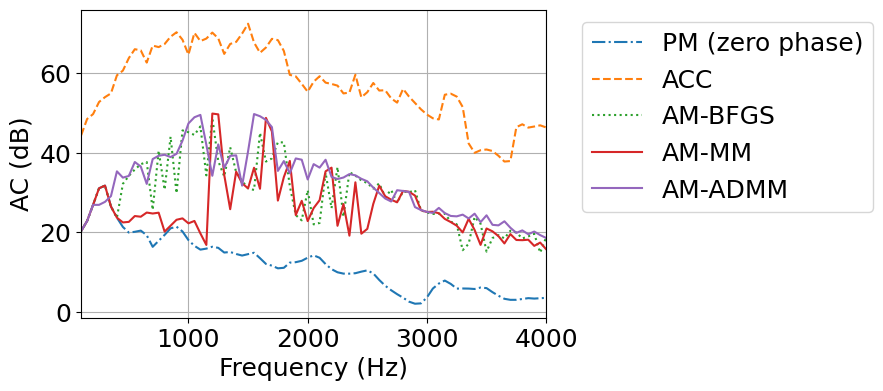

In [20]:
# Parameters
gtol = 1e-3
dtol = 1e-3
max_iter = 1000

freqVec = np.arange(100, 4100, 50)
numFreq = freqVec.shape[0]

MSEvec_PM0 = []
MSEvec_ACC = []
MSEvec_AM_BFGS = []
MSEvec_AM_MM = []
MSEvec_AM_ADMM = []

ACvec_PM0 = []
ACvec_ACC = []
ACvec_AM_BFGS = []
ACvec_AM_MM = []
ACvec_AM_ADMM = []

for i in range(numFreq):
    freq = freqVec[i] # Frequency
    k = 2.0 * np.pi *freq / c # Wave number

    # Transfer Function Matrices
    G = sf.TransFuncMat(posSPK, posCP, k)  
    GU = sf.TransFuncMat(posSPK, posCP_U, k) 
    GL = sf.TransFuncMat(posSPK, posCP_L, k) 

    # Regularization parameter
    U, s, V = np.linalg.svd(G.conj().T @ G)
    reg = np.max(s) * 1e-3
    
    # PM (zero phase)
    drvPM0 = sf.PressureMatching(G, reg, posSPK, des)
    synPM0, _ = sf.SynthSoundField(posSim, posSPK, drvPM0, numSim, k)
    MSEvec_PM0.append(sf.MSE(synPM0[idxCP], des))
    ACvec_PM0.append(sf.AC(synPM0[idxCP_U], synPM0[idxCP_L]))

    # ACC
    drvACC = sf.AcoustContrastControl(GU, GL)
    synACCtmp, _ = sf.SynthSoundField(posSim, posSPK, drvACC, numSim, k)
    ampACC = np.sqrt(synACCtmp[idxCP_U].shape[0]) / np.linalg.norm(synACCtmp[idxCP_U]) 
    drvACC = ampACC * drvACC
    synACC, _ = sf.SynthSoundField(posSim, posSPK, drvACC, numSim, k)
    MSEvec_ACC.append(sf.MSE(synACC[idxCP], des))
    ACvec_ACC.append(sf.AC(synACC[idxCP_U], synACC[idxCP_L]))

    # AM-BFGS
    drv0Cmplx = np.concatenate([drvPM0.real, drvPM0.imag])
    resBFGS = optimize.minimize(sf.CostFuncCmplxAM, drv0Cmplx, method='BFGS', args=(G, des, reg, numSPK), jac=sf.GradCostFuncCmplxAM, options={'gtol': gtol, 'maxiter' : max_iter})
    drvAM_BFGS = resBFGS.x[:numSPK] + 1j * resBFGS.x[numSPK:]
    synAM_BFGS, _ = sf.SynthSoundField(posSim, posSPK, drvAM_BFGS, numSim, k)
    MSEvec_AM_BFGS.append(sf.MSE(synAM_BFGS[idxCP], des))
    ACvec_AM_BFGS.append(sf.AC(synAM_BFGS[idxCP_U], synAM_BFGS[idxCP_L]))

    # AM-MM
    drvAM_MM, _ = sf.MM(numSPK, des, G, reg, drvPM0, dtol=dtol,  max_iter=max_iter)
    synAM_MM, _ = sf.SynthSoundField(posSim, posSPK, drvAM_MM, numSim, k)
    MSEvec_AM_MM.append(sf.MSE(synAM_MM[idxCP], des))
    ACvec_AM_MM.append(sf.AC(synAM_MM[idxCP_U], synAM_MM[idxCP_L]))

    # AM-ADMM
    drvAM_ADMM, _ = sf.ADMM(numSPK, des, G, reg, drvPM0, max_iter=max_iter, dtol=dtol)
    synAM_ADMM, _ = sf.SynthSoundField(posSim, posSPK, drvAM_ADMM, numSim, k)
    MSEvec_AM_ADMM.append(sf.MSE(synAM_ADMM[idxCP], des))
    ACvec_AM_ADMM.append(sf.AC(synAM_ADMM[idxCP_U], synAM_ADMM[idxCP_L]))

# Plot
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(freqVec, MSEvec_PM0, linestyle="-.", label="PM (zero phase)")
ax.plot(freqVec, MSEvec_ACC, linestyle="--", label="ACC")
ax.plot(freqVec, MSEvec_AM_BFGS, linestyle=":", label="AM-BFGS")
ax.plot(freqVec, MSEvec_AM_MM, linestyle="-", label="AM-MM")
ax.plot(freqVec, MSEvec_AM_ADMM, linestyle="-", label="AM-ADMM")
ax.set_xlim(100,4000)
ax.set_ylim(-45, 0)
plt.xlabel('Frequency (Hz)')
plt.ylabel('MSE (dB)')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.grid()

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(freqVec, ACvec_PM0, linestyle="-.", label="PM (zero phase)")
ax.plot(freqVec, ACvec_ACC, linestyle="--", label="ACC")
ax.plot(freqVec, ACvec_AM_BFGS, linestyle=":", label="AM-BFGS")
ax.plot(freqVec, ACvec_AM_MM, linestyle="-", label="AM-MM")
ax.plot(freqVec, ACvec_AM_ADMM, linestyle="-", label="AM-ADMM")
ax.set_xlim(100,4000)
plt.xlabel('Frequency (Hz)')
plt.ylabel('AC (dB)')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.grid()

plt.show()
    

### Figure 7: Performance for desired amplitude distribution of Gaussian

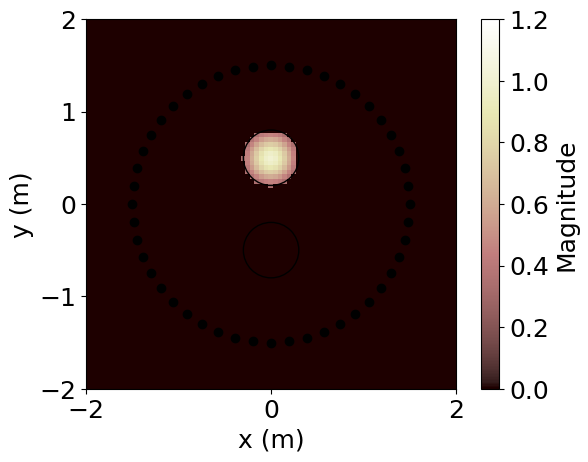

In [21]:
mean = np.array([centCP_U[0,0], centCP_U[0,1]])
cov  = np.array([[0.04, 0.0], [0.0,0.04]])
d = stats.multivariate_normal(mean,cov)
des_U_gauss = d.pdf(posCP_U)/np.max(d.pdf(posCP_U))

des = np.concatenate([des_U_gauss, des_L])

desXY_vec = np.zeros(numSimX*numSimY)
desXY_vec[idxCP] = des
desXY = desXY_vec.reshape((numSimX, numSimY))

# Draw
fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, desXY, cmap='pink', vmin=0.0, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Magnitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.show()

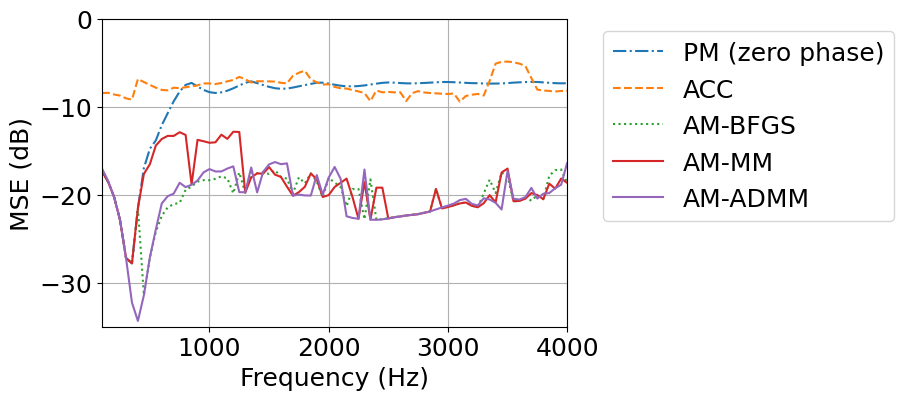

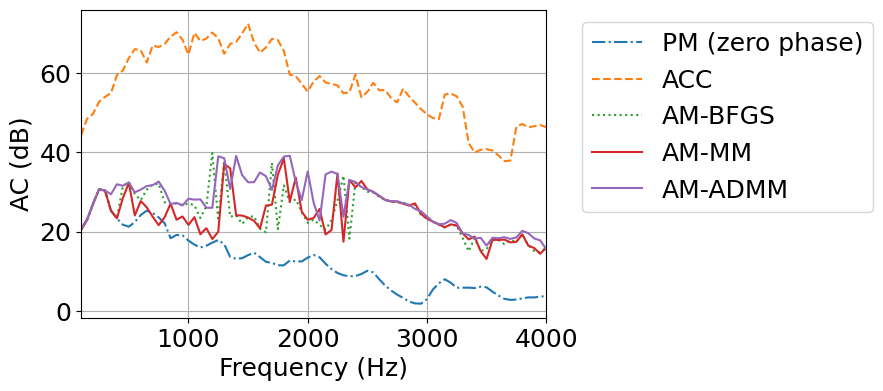

In [22]:
# Parameters
gtol = 1e-3
dtol = 1e-3
max_iter = 1000

freqVec = np.arange(100, 4100, 50)
numFreq = freqVec.shape[0]

MSEvec_PM0 = []
MSEvec_ACC = []
MSEvec_AM_BFGS = []
MSEvec_AM_MM = []
MSEvec_AM_ADMM = []

ACvec_PM0 = []
ACvec_ACC = []
ACvec_AM_BFGS = []
ACvec_AM_MM = []
ACvec_AM_ADMM = []

for i in range(numFreq):
    freq = freqVec[i] # Frequency
    k = 2.0 * np.pi *freq / c # Wave number

    # Transfer Function Matrices
    G = sf.TransFuncMat(posSPK, posCP, k)  
    GU = sf.TransFuncMat(posSPK, posCP_U, k) 
    GL = sf.TransFuncMat(posSPK, posCP_L, k) 

    # Regularization parameter
    U, s, V = np.linalg.svd(G.conj().T @ G)
    reg = np.max(s) * 1e-3
    
    # PM (zero phase)
    drvPM0 = sf.PressureMatching(G, reg, posSPK, des)
    synPM0, _ = sf.SynthSoundField(posSim, posSPK, drvPM0, numSim, k)
    MSEvec_PM0.append(sf.MSE(synPM0[idxCP], des))
    ACvec_PM0.append(sf.AC(synPM0[idxCP_U], synPM0[idxCP_L]))

    # ACC
    drvACC = sf.AcoustContrastControl(GU, GL)
    synACCtmp, _ = sf.SynthSoundField(posSim, posSPK, drvACC, numSim, k)
    ampACC = np.sqrt(synACCtmp[idxCP_U].shape[0]) / np.linalg.norm(synACCtmp[idxCP_U]) 
    drvACC = ampACC * drvACC
    synACC, _ = sf.SynthSoundField(posSim, posSPK, drvACC, numSim, k)
    MSEvec_ACC.append(sf.MSE(synACC[idxCP], des))
    ACvec_ACC.append(sf.AC(synACC[idxCP_U], synACC[idxCP_L]))

    # AM-BFGS
    drv0Cmplx = np.concatenate([drvPM0.real, drvPM0.imag])
    resBFGS = optimize.minimize(sf.CostFuncCmplxAM, drv0Cmplx, method='BFGS', args=(G, des, reg, numSPK), jac=sf.GradCostFuncCmplxAM, options={'gtol': gtol, 'maxiter' : max_iter})
    drvAM_BFGS = resBFGS.x[:numSPK] + 1j * resBFGS.x[numSPK:]
    synAM_BFGS, _ = sf.SynthSoundField(posSim, posSPK, drvAM_BFGS, numSim, k)
    MSEvec_AM_BFGS.append(sf.MSE(synAM_BFGS[idxCP], des))
    ACvec_AM_BFGS.append(sf.AC(synAM_BFGS[idxCP_U], synAM_BFGS[idxCP_L]))

    # AM-MM
    drvAM_MM, _ = sf.MM(numSPK, des, G, reg, drvPM0, dtol=dtol,  max_iter=max_iter)
    synAM_MM, _ = sf.SynthSoundField(posSim, posSPK, drvAM_MM, numSim, k)
    MSEvec_AM_MM.append(sf.MSE(synAM_MM[idxCP], des))
    ACvec_AM_MM.append(sf.AC(synAM_MM[idxCP_U], synAM_MM[idxCP_L]))

    # AM-ADMM
    drvAM_ADMM, _ = sf.ADMM(numSPK, des, G, reg, drvPM0, max_iter=max_iter, dtol=dtol)
    synAM_ADMM, _ = sf.SynthSoundField(posSim, posSPK, drvAM_ADMM, numSim, k)
    MSEvec_AM_ADMM.append(sf.MSE(synAM_ADMM[idxCP], des))
    ACvec_AM_ADMM.append(sf.AC(synAM_ADMM[idxCP_U], synAM_ADMM[idxCP_L]))

# Plot
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(freqVec, MSEvec_PM0, linestyle="-.", label="PM (zero phase)")
ax.plot(freqVec, MSEvec_ACC, linestyle="--", label="ACC")
ax.plot(freqVec, MSEvec_AM_BFGS, linestyle=":", label="AM-BFGS")
ax.plot(freqVec, MSEvec_AM_MM, linestyle="-", label="AM-MM")
ax.plot(freqVec, MSEvec_AM_ADMM, linestyle="-", label="AM-ADMM")
ax.set_xlim(100,4000)
ax.set_ylim(-35, 0)
plt.xlabel('Frequency (Hz)')
plt.ylabel('MSE (dB)')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.grid()

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(freqVec, ACvec_PM0, linestyle="-.", label="PM (zero phase)")
ax.plot(freqVec, ACvec_ACC, linestyle="--", label="ACC")
ax.plot(freqVec, ACvec_AM_BFGS, linestyle=":", label="AM-BFGS")
ax.plot(freqVec, ACvec_AM_MM, linestyle="-", label="AM-MM")
ax.plot(freqVec, ACvec_AM_ADMM, linestyle="-", label="AM-ADMM")
ax.set_xlim(100,4000)
plt.xlabel('Frequency (Hz)')
plt.ylabel('AC (dB)')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.grid()

plt.show()